In [1]:
%%time
import os
import traceback
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import sqlalchemy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.utils import resample
import xgboost as xgb
import seaborn as sns




user='hifld_summer'
pw='hifld_summer'
name='hifld_summer'
host='moria'
port=2023
engine = sqlalchemy.create_engine(
    f'postgresql://{user}:{pw}@{host}:{port}/{name}'
    )

CPU times: total: 3.23 s
Wall time: 3.44 s


In [3]:
%%time
"MODEL SET-UP"
"Loading in the data from the database"

sql ="""
select * from results.all_features_w_class
"""
df = pd.read_sql_query(sql, con=engine)

CPU times: total: 59.2 s
Wall time: 1min 8s


In [4]:
df.columns

Index(['uuid', 'parcel_lid', 'use_code_std_lps', 'use_code_std_desc_lps',
       'geom', 'build_id', 'prim_occ', 'new_sqmeters', 'perimeter',
       'vertex_count', 'length', 'width', 'long_side', 'short_side',
       'ls_ratio', 'pp_compactness', 'min_bounding_circle_area',
       'reock_compactness', 'sch_compactness', 'lon', 'lat',
       'points_in_polygon_buffers', 'ls_ratios_mean', 'ls_ratios_std',
       'ls_ratios_min', 'ls_ratios_max', 'area_mean', 'area_std', 'area_min',
       'area_max', 'mh_flag'],
      dtype='object')

In [5]:
%%time
"Dropping unnecessary columns (leaving only features and label) and setting index"

df = df.drop(columns=['geom', 'use_code_std_lps', 'use_code_std_desc_lps', 'parcel_lid', 'build_id', 'prim_occ'])

df.set_index('uuid', inplace=True)

CPU times: total: 625 ms
Wall time: 611 ms


In [6]:
df.head(2)

,new_sqmeters,perimeter,vertex_count,length,width,long_side,short_side,ls_ratio,pp_compactness,min_bounding_circle_area,...,points_in_polygon_buffers,ls_ratios_mean,ls_ratios_std,ls_ratios_min,ls_ratios_max,area_mean,area_std,area_min,area_max,mh_flag
uuid,,,,,,,,,,,,,,,,,,,,,
{41d5cadc-9dfb-4286-8c95-679ddc040416},505.712776,109.244544,6,38.737520,25.867066,38.73752,25.867066,1.497561,0.532493,1318.869211,...,14,1.184490,0.180276,1.011278,1.497561,195.826218,135.620522,42.908956,505.712776,0
{41d5cfec-707c-4d24-867e-a158aa450156},98.069987,57.020126,6,19.236482,19.350590,19.35059,19.236482,1.005932,0.379044,416.036078,...,5,1.587689,0.606463,1.005932,2.334468,165.185151,83.271834,98.069987,294.207192,0


In [7]:
"Undersampling the minority class in order to reduce class imbalance"

df_class_0 = df[df['mh_flag'] == 0]
df_class_1 = df[df['mh_flag'] == 1]
 
# Oversample minority class
df_class_0_undersampled = resample(df_class_0,
                                  replace=True,      
                                  n_samples=len(df_class_1),  
                                  random_state=13)  
 
df_balanced = pd.concat([df_class_1, df_class_0_undersampled])
print('Balanced dataframe:', df_balanced['mh_flag'].value_counts())
print('Imbalanced dataframe:', df['mh_flag'].value_counts())

Balanced dataframe: mh_flag
1    168074
0    168074
Name: count, dtype: int64
Imbalanced dataframe: mh_flag
0    2315962
1     168074
Name: count, dtype: int64


In [8]:
%%time
"Seperating dataframe into x (features) and y (label)"

X = df_balanced.drop(columns=['mh_flag'], axis=1)
y = df_balanced['mh_flag']

CPU times: total: 78.1 ms
Wall time: 48.3 ms


In [9]:
%%time
"Checking for class imbalance"

df_balanced.mh_flag.value_counts(normalize=True)

CPU times: total: 15.6 ms
Wall time: 15 ms


mh_flag
1    0.5
0    0.5
Name: proportion, dtype: float64

In [10]:
%%time
"Splitting into training and testing datasets"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

CPU times: total: 359 ms
Wall time: 365 ms


In [11]:
%%time
"Standardizing training set and applying the standardization to the training set"

sc = StandardScaler()
sc.fit(X_train)

X_train_scaled = sc.transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

CPU times: total: 172 ms
Wall time: 145 ms


In [12]:
%%time
"Saving the standard scaler"

dump(sc, 'my_standard_scaler.pkl')

CPU times: total: 0 ns
Wall time: 7 ms


['my_standard_scaler.pkl']

In [13]:
%%time
"Loading the standard scaler back"

same_scaler = load('my_standard_scaler.pkl')

CPU times: total: 0 ns
Wall time: 1e+03 µs


In [14]:
%%time
"Applying the standardization to the testing set"


X_test_scaled = same_scaler.transform(X_test)

X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

CPU times: total: 31.2 ms
Wall time: 33.7 ms


In [15]:
"-----CLASSIFICATION MODELS---------------------------------------------------------------------------------------------------------------------------"

'-----CLASSIFICATION MODELS---------------------------------------------------------------------------------------------------------------------------'

In [18]:
%%time
"LINEAR CLASSIFER (BASELINE MODEL)"

base_lr = LogisticRegression(random_state = 42, max_iter=1000)

CPU times: total: 0 ns
Wall time: 0 ns


In [19]:
%%time
"Fitting linear classifier"

base_lr.fit(X_train, y_train)

CPU times: total: 12.7 s
Wall time: 3.27 s


LogisticRegression(max_iter=1000, random_state=42)

In [20]:
%%time
"Using the trained linear classifier to predict on the testing set"

base_lr_predict = base_lr.predict(X_test)

CPU times: total: 31.2 ms
Wall time: 36 ms


In [21]:
%%time
"Checking validity of the linear classifier's output"

base_lr_predict

CPU times: total: 0 ns
Wall time: 0 ns


array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

In [22]:
%%time
"Creating a confusion matrix for the linear classifier"

lr_cmatrix = confusion_matrix(y_test, base_lr_predict)
print(lr_cmatrix)

[[35867 19584]
 [ 9795 45683]]
CPU times: total: 93.8 ms
Wall time: 91.4 ms


In [23]:
%%time
"Creating a classification report for the linear classifier"

print(classification_report(y_test, base_lr_predict))

              precision    recall  f1-score   support

           0       0.79      0.65      0.71     55451
           1       0.70      0.82      0.76     55478

    accuracy                           0.74    110929
   macro avg       0.74      0.74      0.73    110929
weighted avg       0.74      0.74      0.73    110929

CPU times: total: 266 ms
Wall time: 267 ms


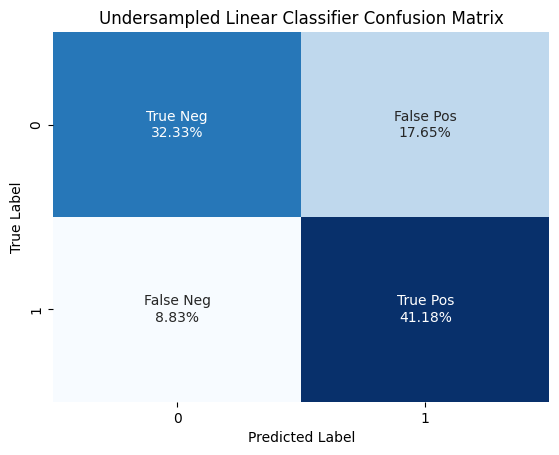

CPU times: total: 141 ms
Wall time: 136 ms


In [25]:
%%time
"Creating a heatmap for the linear classifier's confusion matrix"

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     lr_cmatrix.flatten()/np.sum(lr_cmatrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lr_cmatrix, annot=labels, fmt='', cmap='Blues', cbar=False)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Undersampled Linear Classifier Confusion Matrix')

plt.show()

In [26]:
%%time
"DECISION TREE CLASSIFIER"

base_dt = DecisionTreeClassifier(random_state = 42)

CPU times: total: 0 ns
Wall time: 0 ns


In [27]:
%%time
"Fitting decision tree"

base_dt.fit(X_train, y_train)

CPU times: total: 12.1 s
Wall time: 12.1 s


DecisionTreeClassifier(random_state=42)

In [29]:
%%time
"Using the trained decision tree to predict on the testing set"

base_dt_predict = base_dt.predict(X_test)

CPU times: total: 93.8 ms
Wall time: 87.1 ms


In [30]:
%%time
"Checking validity of the decision tree's output"

base_dt_predict

CPU times: total: 0 ns
Wall time: 0 ns


array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

In [31]:
%%time
"Creating a confusion matrix for the decision tree"

dt_cmatrix = confusion_matrix(y_test, base_dt_predict)
print(dt_cmatrix)

[[39788 15663]
 [16477 39001]]
CPU times: total: 62.5 ms
Wall time: 67.3 ms


In [32]:
%%time
"Creating a classification report for the decision tree"

print(classification_report(y_test, base_dt_predict))

              precision    recall  f1-score   support

           0       0.71      0.72      0.71     55451
           1       0.71      0.70      0.71     55478

    accuracy                           0.71    110929
   macro avg       0.71      0.71      0.71    110929
weighted avg       0.71      0.71      0.71    110929

CPU times: total: 219 ms
Wall time: 207 ms


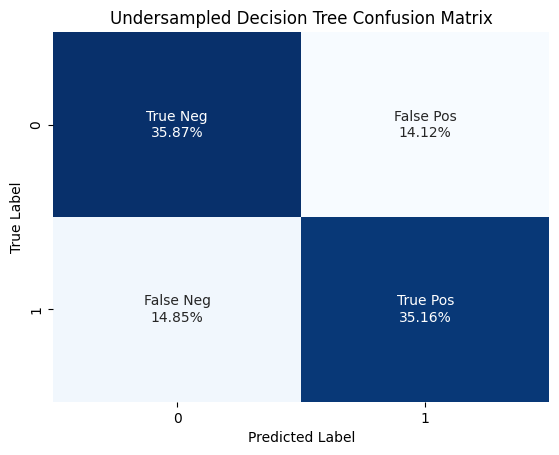

CPU times: total: 109 ms
Wall time: 109 ms


In [33]:
%%time
"Creating a heatmap for the decision tree's confusion matrix"

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     dt_cmatrix.flatten()/np.sum(dt_cmatrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(dt_cmatrix, annot=labels, fmt='', cmap='Blues', cbar=False)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Undersampled Decision Tree Confusion Matrix')

plt.show()

In [34]:
%%time
"RANDOM FOREST CLASSIFIER"

base_rf = RandomForestClassifier(max_depth = 2, random_state = 42)

CPU times: total: 0 ns
Wall time: 226 µs


In [36]:
%%time
"Fitting random forest"

base_rf.fit(X_train, y_train)

CPU times: total: 26.5 s
Wall time: 26.6 s


RandomForestClassifier(max_depth=2, random_state=42)

In [37]:
%%time
"Using the trained random forest to predict on the testing set"

base_rf_predict = base_rf.predict(X_test)

CPU times: total: 688 ms
Wall time: 691 ms


In [38]:
%%time
"Checking validity of the random forest's output"

base_rf_predict

CPU times: total: 0 ns
Wall time: 0 ns


array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

In [39]:
%%time
"Creating a confusion matrix for the random forest"

rf_cmatrix = confusion_matrix(y_test, base_rf_predict)
print(rf_cmatrix)

[[39007 16444]
 [12535 42943]]
CPU times: total: 78.1 ms
Wall time: 64.1 ms


In [40]:
%%time
"Creating a classification report for the random forest"

print(classification_report(y_test, base_rf_predict))

              precision    recall  f1-score   support

           0       0.76      0.70      0.73     55451
           1       0.72      0.77      0.75     55478

    accuracy                           0.74    110929
   macro avg       0.74      0.74      0.74    110929
weighted avg       0.74      0.74      0.74    110929

CPU times: total: 234 ms
Wall time: 239 ms


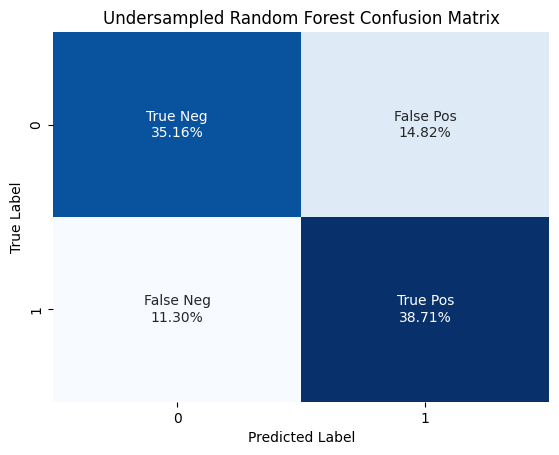

CPU times: total: 141 ms
Wall time: 120 ms


In [42]:
%%time
"Creating a heatmap for the random forest's confusion matrix"

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     rf_cmatrix.flatten()/np.sum(rf_cmatrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(rf_cmatrix, annot=labels, fmt='', cmap='Blues', cbar=False)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Undersampled Random Forest Confusion Matrix')

plt.show()

In [43]:
%%time
"XGBOOST CLASSIFIER"

base_xg = xgb.XGBClassifier(max_depth=2)

CPU times: total: 0 ns
Wall time: 0 ns


In [44]:
%%time
"Fitting random forest"

base_xg.fit(X_train, y_train)

CPU times: total: 6.47 s
Wall time: 963 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [45]:
%%time
"Using the trained random forest to predict on the testing set"

base_xg_predict = base_xg.predict(X_test)

CPU times: total: 266 ms
Wall time: 57.2 ms


In [46]:
%%time
"Checking validity of the random forest's output"

base_xg_predict

CPU times: total: 0 ns
Wall time: 0 ns


array([0, 0, 0, ..., 1, 1, 0])

In [47]:
%%time
"Creating a confusion matrix for the random forest"

xg_cmatrix = confusion_matrix(y_test, base_xg_predict)
print(xg_cmatrix)

[[39525 15926]
 [ 9465 46013]]
CPU times: total: 46.9 ms
Wall time: 51.2 ms


In [48]:
%%time
"Creating a classification report for the random forest"

print(classification_report(y_test, base_xg_predict))

              precision    recall  f1-score   support

           0       0.81      0.71      0.76     55451
           1       0.74      0.83      0.78     55478

    accuracy                           0.77    110929
   macro avg       0.77      0.77      0.77    110929
weighted avg       0.77      0.77      0.77    110929

CPU times: total: 234 ms
Wall time: 235 ms


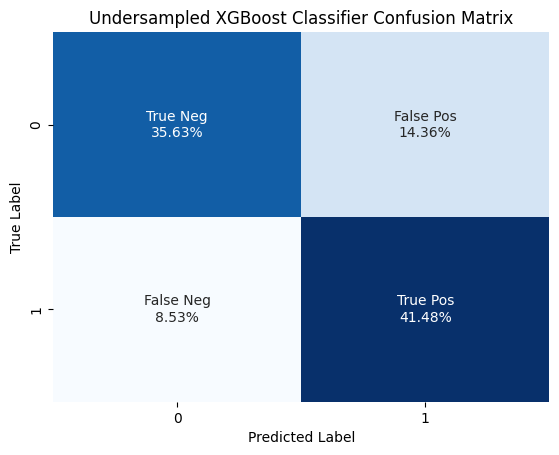

CPU times: total: 156 ms
Wall time: 142 ms


In [49]:
%%time
"Creating a heatmap for the random forest's confusion matrix"

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     xg_cmatrix.flatten()/np.sum(xg_cmatrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(xg_cmatrix, annot=labels, fmt='', cmap='Blues', cbar=False)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Undersampled XGBoost Classifier Confusion Matrix')

plt.show()